In [1]:
import numpy as np
import pandas as pd
import tflearn
import tensorflow as tf
# Remove regular python warnings
import warnings
warnings.filterwarnings('ignore')
# Remove TensorFlow warnings
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib.pyplot as plt
%matplotlib inline

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
data = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train = data.ix[:,1:]
labels = data.ix[:,0:1]
data = pd.concat([train, test], ignore_index=True)

In [4]:
print(train.shape)
print(labels.shape)
print(test.shape)
print(data.shape)

(42000, 784)
(42000, 1)
(28000, 784)
(70000, 784)


Data Standardisation
==========

Pixel values goes from 255 to 0. To speedup the training process we can standardizate the data. The changes to apply:
* Zero Mean
* Low variance

Some have stdev 0, so the result will be NaN. We change those to 0.

In [5]:
norm_data = (data - data.mean())/data.std()
norm_data = norm_data.fillna(0)

# Labels Hot-Encoding

In [6]:
labels[0:10]

,label
0,1
1,0
2,1
3,4
4,0
5,0
6,7
7,3
8,5
9,3


In [7]:
norm_labels = []
for value in labels.iterrows():
    new_label = np.zeros(10)
    new_label[value[1]]=1
    norm_labels.append(new_label)
norm_labels = np.array(norm_labels)

In [8]:
print(labels.ix[12:12,0:1])
print(norm_labels[12])

    label
12      1
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


# Preparing the data for TensorFlow

In [9]:
train = norm_data.as_matrix()[0:42000]
test = norm_data.as_matrix()[42000:]

# Neural Network

Characteristics:

* An input layer
* A hidden layer with ReLu activation
* An output layer using softmax
* Backpropagation using Stochastic Gradient Descent
* Cross-entropy with labels

In [10]:
tf.reset_default_graph()

## Input Layer

In [11]:
net = tflearn.input_data(shape=[None, 784])

## Hidden Layer

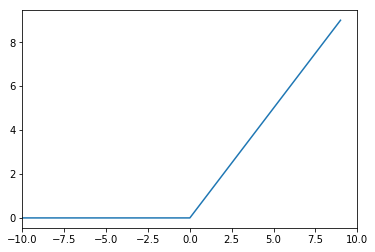

In [12]:
x=np.arange(-10,10,1)
y=np.maximum(x, 0)
plt.plot(x,y)
plt.xlim(-10,10)
plt.show()

In [13]:
net = tflearn.fully_connected(net, 128, activation='ReLu')
# add a second hidden layer
net = tflearn.fully_connected(net, 64, activation='ReLu')
# third layer, better going deeper than wider
net = tflearn.fully_connected(net, 32, activation='ReLu')

## Output layer

It has 10 neurons, one for each possible number. It uses softmax as the activation function. Softmax is a probability distribution function. It highlights the largest value and suppress values which are significantly below the maximum one.

### Example

In [14]:
i=np.array([1,2,3,4,1,2,3,7])

After applying softmax

In [15]:
o = np.exp(i)/np.sum(np.exp(i))
o

array([ 0.00224352,  0.00609851,  0.01657746,  0.04506222,  0.00224352,
        0.00609851,  0.01657746,  0.90509881])

And since softmax is a probability distribution, it sums up to 1.

In [16]:
int(np.sum(o))

1

In [17]:
net = tflearn.fully_connected(net, 10, activation='softmax')

# Regression with Gradient Descent

In [18]:
net = tflearn.regression(net, optimizer='sgd', learning_rate=0.01, loss='categorical_crossentropy')
model = tflearn.DNN(net)

In [19]:
model.fit(train, norm_labels,show_metric=True,validation_set=0.1,batch_size=100, n_epoch=50)

Training Step: 18899  | total loss: 0.06393 | time: 3.619s
| SGD | epoch: 050 | loss: 0.06393 - acc: 0.9848 -- iter: 37700/37800
Training Step: 18900  | total loss: 0.06147 | time: 4.684s
| SGD | epoch: 050 | loss: 0.06147 - acc: 0.9853 | val_loss: 0.22440 - val_acc: 0.9457 -- iter: 37800/37800
--


# Predictions
Predict first few numbers

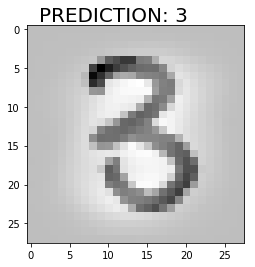

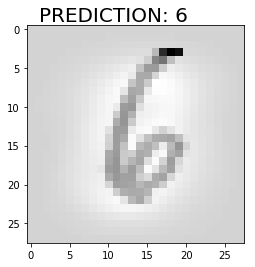

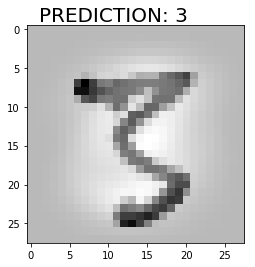

In [21]:
for i in range(3):
    ran=np.random.randint(0, test.shape[0])
    pred=model.predict(test)[ran]
    pred_digit=pred.index(max(pred))
    digit=test[ran].reshape(28,28)
    plt.imshow(digit, cmap='gray_r')
    plt.text(1, -1,"PREDICTION: {}".format(pred_digit),fontsize=20) 
    plt.show()

# Predict test's labels

In [22]:
ids=[]
predictions=[]
pred=model.predict(test)
for i, values in enumerate(pred):
    pred_digit=values.index(max(values))
    ids.append(i+1)
    predictions.append(pred_digit)

In [24]:
# Make predictions
sub = pd.DataFrame({
    "ImageId": ids,
    "Label": predictions
})

sub.to_csv("submission.csv", index=False)